[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aunz/ds/blob/master/KNN.ipynb)

# k Nearest Neighbors


We will implement k nearest neighbors in Python and hopefully at the end of this notebook, you will understand how it work.

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import the iris dataset from sklearn
iris = __import__('sklearn').datasets.load_iris()

# overview of the data
print('Number of observation: {}\nNumber of feature: {}'.format(*iris.data.shape))
print('Target category:', iris.target_names)
pd.DataFrame(iris.data, columns=iris.feature_names, index=iris.target).head(10)

Number of observation: 150
Number of feature: 4
Target category: ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
0,4.9,3.0,1.4,0.2
0,4.7,3.2,1.3,0.2
0,4.6,3.1,1.5,0.2
0,5.0,3.6,1.4,0.2
0,5.4,3.9,1.7,0.4
0,4.6,3.4,1.4,0.3
0,5.0,3.4,1.5,0.2
0,4.4,2.9,1.4,0.2
0,4.9,3.1,1.5,0.1


In this dataset, there are:
- 150 observations
- 4 features: sepal length, sepal width, petal length, petal width
- 3 species of flower in the dataset: Setosa (0), Versicolor (1), Virginica (2). 

From the graphs below, we can see that each species can be more or less clustered together using various features. For example, setosa has smaller petal septal length, petal length and petal width compared to the other two species.

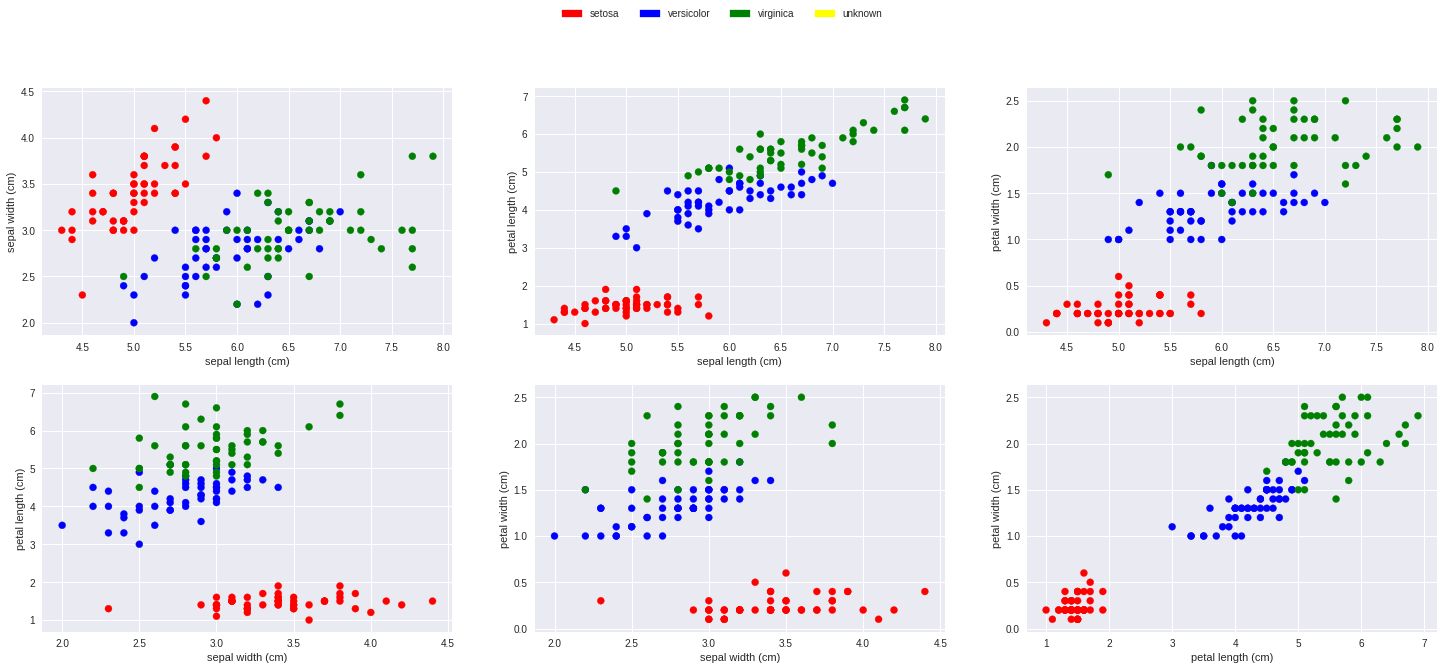

In [128]:
# a helper function to plot
def plot(ax, x1, x2):
    colors = list(map(lambda x: { 0: 'red', 1: 'blue', 2: 'green', 3: 'yellow' }[x], iris.target))
    ax.scatter(iris.data[:, x1], iris.data[:, x2], c=colors)
    ax.set_xlabel(iris.feature_names[x1])
    ax.set_ylabel(iris.feature_names[x2])

fig, ax = plt.subplots(2, 3, figsize=(25, 10))
plot(ax[0][0], 0, 1)
plot(ax[0][1], 0, 2)
plot(ax[0][2], 0, 3)
plot(ax[1][0], 1, 2)
plot(ax[1][1], 1, 3)
plot(ax[1][2], 2, 3)

fig.legend(handles=[
    mpatches.Patch(color='red', label=iris.target_names[0]),
    mpatches.Patch(color='blue', label=iris.target_names[1]),
    mpatches.Patch(color='green', label=iris.target_names[2]),
    mpatches.Patch(color='yellow', label='unknown'),
], loc='upper center', ncol=4);


The question is: given a sample without a label, can we classify it using its features?

The graph below shows 4 such new samples, can you guess their labels?
- Sample 1 is close to Setosa, so it's likely to be Setosa,
- Sample 2 is close to Virginica, so it's likely to be Virginica
- Sample 3 is close to both Versicolor and Virginica, can be either
- Sample 4 is close to both Versicolor and Virginica too, can be either

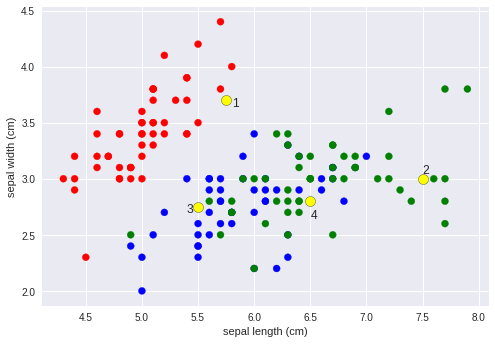

In [180]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(1, 1)
plot(ax, 0, 1)

ax.scatter([5.75], [3.7], c='yellow', edgecolor='black', s=100); ax.text(5.8, 3.65, '1') # sample 1
ax.scatter([7.5], [3.0], c='yellow', edgecolor='black', s=100); ax.text(7.5, 3.05, '2') # sample 2
ax.scatter([5.5], [2.75], c='yellow', edgecolor='black', s=100); ax.text(5.4, 2.7, '3', horizontalalignment='left') # sample 3
ax.scatter([6.5], [2.8], c='yellow', edgecolor='black', s=100); ax.text(6.5, 2.65, '4'); # sample 4
# ax.add_patch(mpatches.Circle(xy=(5.75, 3.7), radius=0.1, facecolor='none', edgecolor='black'))